In [73]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [74]:
#data
baseball = pd.read_csv('data/Hitters.csv')

In [75]:
#Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. 
#How will you handle missing data?
#Are there any variables that need adjusting?

#clean data
#find number of NA's per column
na_counts = baseball.isna().sum()
print(na_counts)

#only NA's are salary
#for now will choose to remove the observations where salary is NA
baseball = baseball.dropna()


#another thing we could do, but does not seem to important for this model is that we save the values that dont have a corresponding and we use it as a test dataset for our model.
#that way we our using our model on new data and not data that it was already built on.

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


**Part I: Different Model Specs**

**A. Regression without regularization**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

**#1**

In [76]:

#Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_linear = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [77]:
# Fit and transform the data
X_1 = ct.fit_transform(X)

# Retrieve feature names
#REFRENCED CHAT GPT TO GET COLUMN NAMES TO MAKE SURE ALL COLS WERE SELECTED
ohe_feature_names = ct.named_transformers_['dummify'].get_feature_names_out(X.select_dtypes(include='object').columns)
num_feature_names = X.select_dtypes(include=np.number).columns
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

# Create a DataFrame with the transformed data
X_1_df = pd.DataFrame(X_1, columns=all_feature_names)
#X_1_df.head()

#all columns are there

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**#2**

In [78]:
# Fit the pipeline to the full dataset
lr_pipeline_linear.fit(X, y)

# Get feature names from the ColumnTransformer
#REFRENCED CHAT GPT TO GET COLUMN NAMES TO MAKE SURE ALL COLS WERE SELECTED
ohe_feature_names = ct.named_transformers_['dummify'].get_feature_names_out(X.select_dtypes(include='object').columns)
num_feature_names = X.select_dtypes(include=np.number).columns
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

# Get coefficients from the linear regression model
coefficients = lr_pipeline_linear.named_steps["linear_regression"].coef_

# Create a DataFrame to display feature names and their corresponding coefficients
coeff_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

# Display the top coefficients
coeff_df


,Feature,Coefficient
0,League_A,-31.299712
1,League_N,31.299712
2,Division_E,58.424623
3,Division_W,-58.424623
4,NewLeague_A,12.381163
5,NewLeague_N,-12.381163
6,AtBat,-291.094556
7,Hits,337.830479
8,HmRun,37.853837
9,Runs,-60.572479


Some of the most important coefficients in this case, we see that we have all the categorical options for all the dummy variables we converted. So in order to accurately estimate that we would find the total amount between the two groups.

For instance for league_N and league_A: A player's salary is estimated to make 31.299712+31.299712=62.599424 thousand MORE if they play in the A league versus the N league. This would work the same for the NewLeague dummy variable as well as the Division dummy variable.

The highest coefficients we see in our models are CRuns: 480, Hits: 337 and CAtBat: -391

CRuns: For every 1 standard deviation increase in number of home runs during a player's career, there is an estimated 480 (thousand) increase in that players salary

Hits: For every 1 standard deviation increase in the player's number of hits in 1986, there is an estimated 337 (thousand) increase in that players salary

CAtBat: For every 1 standard deviation increase in the player's number of times at bar during their career, there is an estimated -391 (thousand) DECREASE in that players salary

**#3**

In [79]:
#Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.3456645862518122  mse:  120656.57125044877
r2:  0.3456645862518122  mse:  120656.57125044877


**B. Ridge regression**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

**#1**

In [80]:
#Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))]
).set_output(transform="pandas")

**#2**

In [81]:
#Use cross-validation to tune the hyperparameter.

#tune lambdas to test multiple vals
lambdas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_1, lambdas, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,ridge_regression__alpha,scores
5,100.000,0.385012
4,10.000,0.368328
3,1.000,0.355767
2,0.100,0.347675
1,0.010,0.344084
0,0.001,0.343556


**#3**

In [82]:
#Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_ridge = Pipeline(
  [("preprocessing", ct),
  #changed alpha = 100
  ("ridge_regression", Ridge(alpha = 100))]
).set_output(transform="pandas")

In [83]:
#output all variables coeff.
# Fit the pipeline to the full dataset
lr_pipeline_ridge.fit(X, y)

# Get feature names from the ColumnTransformer
#REFRENCED CHAT GPT TO GET COLUMN NAMES TO MAKE SURE ALL COLS WERE SELECTED
ohe_feature_names = ct.named_transformers_['dummify'].get_feature_names_out(X.select_dtypes(include='object').columns)
num_feature_names = X.select_dtypes(include=np.number).columns
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

# Get coefficients from the linear regression model
coefficients = lr_pipeline_ridge.named_steps["ridge_regression"].coef_

# Create a DataFrame to display feature names and their corresponding coefficients
coeff_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

# Display the top coefficients
coeff_df

,Feature,Coefficient
0,League_A,-11.051842
1,League_N,11.051842
2,Division_E,38.023222
3,Division_W,-38.023222
4,NewLeague_A,-4.091590
5,NewLeague_N,4.091590
6,AtBat,-0.567370
7,Hits,49.612386
8,HmRun,-1.464159
9,Runs,29.343263


The main changes we see are that a lot of the very large coefficients of variables have changed (specifically CRuns, Hits, and CAtBat). Additionally, the coefficient for CAtBat is now positive!

CRuns: For every 1 standard deviation increase in number of home runs during a player's career, there is an estimated 44.53 (thousand) increase in that players salary

Hits: For every 1 standard deviation increase in the player's number of hits in 1986, there is an estimated 49.61 (thousand) increase in that players salary

CAtBat: For every 1 standard deviation increase in the player's number of times at bar during their career, there is an estimated 24.70 (thousand) INCREASE in that players salary)

Overall most of the coefficients of our predictors are lower.

Some of the other most important coefficients now include PutOuts and CRBI

**#4**

In [84]:
#Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_ridge, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.3850122123151716  mse:  120716.43558937623
r2:  0.3850122123151716  mse:  120716.43558937623


**C. Lasso Regression**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the alpha hyperparameter.

3. Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

**#1**

In [85]:
#Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary lasso regression

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 1))]
).set_output(transform="pandas")

**#2**

In [86]:
#Use cross-validation to tune the hyperparameter.

#tune lambdas to test multiple vals
lambdas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_1, lambdas, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, toler

,lasso_regression__alpha,scores
4,10.000,0.369523
3,1.000,0.354238
2,0.100,0.346041
1,0.010,0.344394
0,0.001,0.344223
5,100.000,0.298382


**#3**

In [87]:
#Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_lasso = Pipeline(
  [("preprocessing", ct),
  #changed alpha = 10
  ("lasso_regression", Lasso(alpha = 10))]
).set_output(transform="pandas")

In [88]:
#output all variables coeff.
# Fit the pipeline to the full dataset
lr_pipeline_lasso.fit(X, y)

# Get feature names from the ColumnTransformer
#REFRENCED CHAT GPT TO GET COLUMN NAMES TO MAKE SURE ALL COLS WERE SELECTED
ohe_feature_names = ct.named_transformers_['dummify'].get_feature_names_out(X.select_dtypes(include='object').columns)
num_feature_names = X.select_dtypes(include=np.number).columns
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

# Get coefficients from the linear regression model
coefficients = lr_pipeline_lasso.named_steps["lasso_regression"].coef_

# Create a DataFrame to display feature names and their corresponding coefficients
coeff_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

# Display the top coefficients
coeff_df

,Feature,Coefficient
0,League_A,-0.000000e+00
1,League_N,0.000000e+00
2,Division_E,9.541320e+01
3,Division_W,-3.327948e-12
4,NewLeague_A,-0.000000e+00
5,NewLeague_N,0.000000e+00
6,AtBat,-0.000000e+00
7,Hits,8.874163e+01
8,HmRun,0.000000e+00
9,Runs,0.000000e+00


With our hyperparameter (alpha = 10). Above are the coefficients from the optimized lasso model using every variable.

Some of the most important changes we see in our coefficients is that many of the ones that the lasso model deemed as redundant or unimportant are now zero'd out. These variables include but are not limited to League, Runs, and Years.

The variables the method chose to be the most "important" include Division, Hits, Walks, CRuns, CRBI, PutOuts, and Errors.

Hits: For every 1 standard deviation increase in the player's number of hits in 1986, there is an estimated 8.874163e+01 (thousand) increase in that players salary

Walks: For every 1 standard deviation increase in the player's number of walks in 1986, there is an estimated 4.990281e+01(thousand) increase in that players salary

PutOuts: For every 1 standard deviation increase in the player's number of put outs in 1986, there is an estimated 6.673701e+01(thousand) increase in that players salary

(can interpret like this too it should work, although its not the same way I did for the ordinary regression output)
Division_W: If a player division at the end of 1986 was level W, there is an estimated -3.327948e-12 (thousand) DECREASE in that players salary

Division_E: If a player division at the end of 1986 was level E, there is an estimated 9.541320e+01 (thousand) increase in that players salary

**#4**

In [89]:
#Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_lasso, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.3695225743376409  mse:  121828.14133338635
r2:  0.3695225743376409  mse:  121828.14133338635


**D. Elastic Net**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary elastic net regression

2. Use cross-validation to tune the lambda and alpha hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

**#1**

In [90]:
#Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary elastic net regression

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_regression", ElasticNet(alpha = .01, l1_ratio = .5))]
).set_output(transform="pandas")

**#2**

In [91]:
#Use cross-validation to tune the lambda and alpha hyperparameters.

#Use cross-validation to tune the hyperparameter.

#tune lambdas/alphas to test multiple vals
values = {"elastic_regression__alpha": [.001, .01, .1, 1, 10, 100],
          "elastic_regression__l1_ratio": [.1, .2, .3, .4, .5, .6, .7, .8, .9]}

gscv = GridSearchCV(lr_pipeline_1, values, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+07, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+07, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.060e+06, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.579e+06, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.601e+03, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+05, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+04, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.792e+05, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.632e+04, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.947e+04, toler

,elastic_regression__alpha,elastic_regression__l1_ratio,scores
28,1.0,0.2,0.386643
29,1.0,0.3,0.386557
27,1.0,0.1,0.386511
30,1.0,0.4,0.386203
31,1.0,0.5,0.385538


**#3**

In [92]:
#Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_elastic = Pipeline(
  [("preprocessing", ct),
  #can now put our custom alpha and l1_ratio that we found in the previous step
  ("elastic_regression", ElasticNet(alpha = 1, l1_ratio = .2))]
).set_output(transform="pandas")

In [93]:
#output all variables coeff.
# Fit the pipeline to the full dataset
lr_pipeline_elastic.fit(X, y)

# Get feature names from the ColumnTransformer
#REFRENCED CHAT GPT TO GET COLUMN NAMES TO MAKE SURE ALL COLS WERE SELECTED
ohe_feature_names = ct.named_transformers_['dummify'].get_feature_names_out(X.select_dtypes(include='object').columns)
num_feature_names = X.select_dtypes(include=np.number).columns
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

# Get coefficients from the linear regression model
coefficients = lr_pipeline_elastic.named_steps["elastic_regression"].coef_

# Create a DataFrame to display feature names and their corresponding coefficients
coeff_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

# Display the top coefficients
coeff_df

,Feature,Coefficient
0,League_A,-7.248569
1,League_N,7.248595
2,Division_E,26.103984
3,Division_W,-26.103971
4,NewLeague_A,-4.116523
5,NewLeague_N,4.116546
6,AtBat,12.179419
7,Hits,37.450668
8,HmRun,5.609999
9,Runs,27.011028


The elastic regression with parameters lambda = 1 and l1_ratio = .2 definitely has similiar coefficients to the previous steps (that is because the elastic regression uses a combination of two calculations to find its own penalty formula) Where that ratio of which type is more effective is determined by the l1_ratio.

Because 0 would mean a pure ridge regression and 1 would mean a pure lasso regression

that means that essentially 80% of the penalty weight is on a ridge penalty and 20% is on a lasso penalty. As a result we can see that are values are a lot more similiar to the ridge regression, (even though we used a completely different alpha value)

**Some of the most notable coefficient changes from the previous regression (lasso) are that many of the variables that were not zero'd out are here and very large (this is most likely because the variables have a lot of multicollinearity between them such as CHits and Hits being extremely correlated). We see that almost every variable has been significantly changed and that there are unlike the previous model, PutOuts is now the variable with the highest coefficient (when before it was Hits)

Interpretation of Walks output: For every 1 standard deviation increase in a players number of walks in 1986, their salary is expected to increase by 34.56 (thousand)

**#4**

In [94]:
#Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_elastic, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_elastic, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

#this combination has given us the highest R^2 and lowest MSE compared to all the previous regression with their corresponding hyperparameters

r2:  0.3866433466516488  mse:  121500.81646251371
r2:  0.3866433466516488  mse:  121500.81646251371


**Part II. Variable Selection**

Based on the above results, decide on:

- Which numeric variable is most important.

- Which five numeric variables are most important

- Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: 
 and 
 must be re-tuned for each feature set.)

**Variable Selection**

1. Most Important Numeric Variable: CRuns

2. Top 5 Most Important Numeric Variables: CRuns, PutOuts, Hits, CRBI, Walks

3. Most Important Categorical Variable: Division

**A. Regression without regularization**

**#1**

In [95]:
#Using only the one best numeric variable.
X = baseball[["CRuns"]]
y = baseball["Salary"]

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.29227548589102115  mse:  143812.9359162973
r2:  0.29227548589102115  mse:  143812.9359162973


**#2**

In [96]:
#Using only the five best variables.
X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]]
y = baseball["Salary"]

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.37722674799137945  mse:  121332.85377811702
r2:  0.37722674799137945  mse:  121332.85377811702


**#3**

In [97]:
#Using the five best numeric variables and their interactions with the one best categorical variable.

X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks", "Division"]]
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["Division"]),
    ("standardize", StandardScaler(), ["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]),
  ],
  remainder = "drop"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that division by itself is not included in the model
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ("interaction_Hits_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction_CRBI_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction_Walks_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Walks", "dummify__Division_W"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


lr_pipeline_linear = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")



In [98]:
#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_linear, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.320279729122522  mse:  130401.97016858231
r2:  0.320279729122522  mse:  130401.97016858231


**B. Ridge regression**

**#1**

In [99]:
#retune hyperparameter and score how well the model did (in MSE)

#Using only the one best numeric variable.
X = baseball[["CRuns"]]
y = baseball["Salary"]

#tune lambdas to test multiple vals
lambdas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_ridge, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True)



,ridge_regression__alpha,scores
4,10.000,143658.517369
3,1.000,143783.706854
2,0.100,143809.862456
1,0.010,143812.627051
0,0.001,143812.905015
5,100.000,148807.783475


**#2**

In [100]:
#retune hyperparameter and score how well the model did (in MSE)

#Using only the five best variables.
X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]]
y = baseball["Salary"]

#tune lambdas to test multiple vals
lambdas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_ridge, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True)


,ridge_regression__alpha,scores
5,100.000,119398.400113
4,10.000,119969.294948
3,1.000,121103.353500
2,0.100,121307.910944
1,0.010,121330.337137
0,0.001,121332.601888


**#3**

In [101]:
#pipeline
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["Division"]),
    ("standardize", StandardScaler(), ["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]),
  ],
  remainder = "drop"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that division by itself is not included in the model
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ("interaction_Hits_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction_CRBI_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction_Walks_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Walks", "dummify__Division_W"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


lr_pipeline_ridge = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
   ("ridge_regression", Ridge(alpha = 100))]
).set_output(transform="pandas")


In [102]:
#retune hyperparameter

#Using the five best numeric variables and their interactions with the one best categorical variable.

X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks", "Division"]]
y = baseball["Salary"]

#tune lambdas to test multiple vals
lambdas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_ridge, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores'] * -1

results_df.sort_values(by = 'scores', ascending = True).head()

,ridge_regression__alpha,scores
5,100.00,116972.675912
4,10.00,118503.794116
3,1.00,125192.212120
2,0.10,129543.747309
1,0.01,130310.159254


**C. Lasso Regression**

**#1**

In [103]:
#retune hyperparameter and score how well the model did (in MSE)

#Using only the one best numeric variable.
X = baseball[["CRuns"]]
y = baseball["Salary"]

#tune lambdas to test multiple vals
lambdas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_lasso, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True)



,lasso_regression__alpha,scores
4,10.000,143793.449159
3,1.000,143801.606084
2,0.100,143811.709122
1,0.010,143812.812299
0,0.001,143812.923545
5,100.000,152999.224797


**#2**

In [104]:
#retune hyperparameter and score how well the model did (in MSE)

#Using only the five best variables.
X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]]
y = baseball["Salary"]

#tune lambdas to test multiple vals
lambdas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_lasso, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True)


,lasso_regression__alpha,scores
1,0.010,121332.402601
2,0.100,121332.659779
0,0.001,121332.893433
3,1.000,121337.557109
4,10.000,121600.010609
5,100.000,142592.153396


**#3**

In [105]:
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["Division"]),
    ("standardize", StandardScaler(), ["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]),
  ],
  remainder = "drop"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that division by itself is not included in the model
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ("interaction_Hits_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction_CRBI_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction_Walks_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Walks", "dummify__Division_W"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


lr_pipeline_lasso = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("lasso_regression", Lasso(alpha = 10))]
).set_output(transform="pandas")


In [106]:
#retune hyperparameter and score how well the model did (in MSE)

#Using the five best numeric variables and their interactions with the one best categorical variable.
X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks", "Division"]]
y = baseball["Salary"]

#tune lambdas to test multiple vals
lambdas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_lasso, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.266e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+04, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.136e+05, toler

,lasso_regression__alpha,scores
4,10.000,119129.330501
3,1.000,126202.590816
2,0.100,129953.501522
1,0.010,130358.354217
0,0.001,130397.415306
5,100.000,142592.153396


**D. Elastic Net**

**#1**

In [107]:
#Using only the one best numeric variable.
X = baseball[["CRuns"]]
y = baseball["Salary"]

#Use cross-validation to tune the lambda and alpha hyperparameters.

#tune lambdas/alphas to test multiple vals
values = {"elastic_regression__alpha": [.001, .01, .1, 1, 10, 100],
          "elastic_regression__l1_ratio": [.1, .2, .3, .4, .5, .6, .7, .8, .9]}

gscv = GridSearchCV(lr_pipeline_elastic, values, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True).head()

,elastic_regression__alpha,elastic_regression__l1_ratio,scores
22,0.1,0.5,143655.076048
21,0.1,0.4,143660.021761
23,0.1,0.6,143661.305279
20,0.1,0.3,143675.521978
24,0.1,0.7,143679.366378


**#2**

In [108]:
#Using only the five best variables.
X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]]
y = baseball["Salary"]

#tune lambdas/alphas to test multiple vals
values = {"elastic_regression__alpha": [.001, .01, .1, 1, 10, 100],
          "elastic_regression__l1_ratio": [.1, .2, .3, .4, .5, .6, .7, .8, .9]}

gscv = GridSearchCV(lr_pipeline_elastic, values, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True).head()

,elastic_regression__alpha,elastic_regression__l1_ratio,scores
33,1.0,0.7,118839.350432
34,1.0,0.8,118860.691338
32,1.0,0.6,119107.904838
35,1.0,0.9,119352.498787
18,0.1,0.1,119416.439601


**#3**

In [109]:
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["Division"]),
    ("standardize", StandardScaler(), ["CRuns", "PutOuts", "Hits", "CRBI", "Walks"]),
  ],
  remainder = "drop"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that division by itself is not included in the model
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ("interaction_Hits_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction_CRBI_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction_Walks_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Walks", "dummify__Division_W"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#elastic pipeline
lr_pipeline_elastic = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("elastic_regression", ElasticNet(alpha = 1, l1_ratio = .8))]
).set_output(transform="pandas")


In [110]:
#Using the five best numeric variables and their interactions with the one best categorical variable.

X = baseball[["CRuns", "PutOuts", "Hits", "CRBI", "Walks", "Division"]]
y = baseball["Salary"]

#tune lambdas/alphas to test multiple vals
values = {"elastic_regression__alpha": [.001, .01, .1, 1, 10, 100],
          "elastic_regression__l1_ratio": [.1, .2, .3, .4, .5, .6, .7, .8, .9]}

gscv = GridSearchCV(lr_pipeline_elastic, values, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df['scores'] = results_df['scores']*-1

results_df.sort_values(by = 'scores', ascending = True).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.991e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+07, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.757e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+07, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.830e+06, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.554e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.021e+07, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.638e+06, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.559e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.533e+05, toler

,elastic_regression__alpha,elastic_regression__l1_ratio,scores
34,1.0,0.8,115700.337508
33,1.0,0.7,115902.392141
32,1.0,0.6,116443.528508
35,1.0,0.9,116452.419582
18,0.1,0.1,116925.964283


**Part 2 Conclusion**

From all the combinations of features and models, the best performing one is using an elastic regression with parameters alpha = 1 and l1_ratio = .8.

The variables included in the model were five best numeric variables and their interactions with the one best categorical variable

So in this case it was the following variables: "CRuns", "PutOuts", "Hits", "CRBI", "Walks", "Division"

the MSE value I got for the best model (so the lowest MSE) is 115700.337508

**Part III. Discussion**

**A. Ridge**

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

For part 1 (every variable):
ordinary regression outputs: 
r2: 0.3456645862518122

ridge regression outputs:
r2: 0.385012


For Part 2 (for different various selection of variables):
ordinary regression outputs: 
1. mse:  143812.9359162973
2. mse:  121332.85377811702
3. mse:  130401.97016858231

ridge regression outputs:
1. mse: 143658.517369
2. mse: 119398.400113
3. mse: 116972.675912

Overall, the ridge regression models typically gave better performance when compared to the ordinary regression models. 

In terms of coefficients, for ridge regression the coefficients were typically smaller than those from ordianry regresion. This is be cause the ridge is introducing the penalty in which the penalty was shrinking coefficients toward 0. The reason that this makes sense is because this penalty will typically help with a few reasons (which are reducing multicollinearity and preventing overfitting of the model). So in the cases where there were many more varaibles in the model, we can see that the ridge regression method proved even more effective than the ordinary regression method.

**B. LASSO**

Compare your LASSO model in I with your three LASSO models in II. Did you get the same results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

For part 1 (every variable). lasso regression output:
mse:  121828.14133338635

For part 2 (model including the following variable selection).
1. best numeric variable
mse: 143793.449159
2. top 5 numeric variable
mse: 121332.402601
3. top 5 numeric variable AND their corresponding interaction with the best categorical variable
mse: 119129.330501

The model including every variable had a very similiar mse to the model including the top 5 variable in part 2. With our last model in part 2 having the best mse score and first model in part 2 having the worst score out of all the lasso regressions.

The differences we observe make sense because the LASSO regression is penalizing the less impactful variables (which can be done by shrinking their coefficients to 0). This resduced the model complexity and thus helps get better MSE values. We can see that especially see this happening for the model including every variable because many of the coefficients end up being 0 and we get a similiar score to a model that only used 5 variables as the predictor (but they were all considered effective)

**C. Elastic Net**

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

elastic model mse scores
part 1 (every variable):
1. mse: 121500.81646251371

For part 2 (model including the following variable selection).
1. best numeric variable
mse: 143655.076048
2. top 5 numeric variable
mse: 118839.350432
3. top 5 numeric variable AND their corresponding interaction with the best categorical variable
mse: 115700.337508

Elastic net will always have an advantage over both the ridge and lasso methods because it combines them and optimizes.
In part 1, the Elastic net did slightly better than the lasso (but not by much)

In part 2 we can see that the elastic net method does better than ridge and lasso even when we only incorporated one variable (or many variables). Because the lasso and ridge models vary, it is hard to find a good balance for each, but because we are using gridsearch we are purposely optimizing to find the best combination to yield the highest mse score.

In addition, how the elastic net combines both regression methods is by using both of their penalties. Thus elastic net is able to zero (if needed) out the irrelevent coefficients but is also able to keep the model stable and sometimes only minimize coefficients and keep too many (like ridge).

This process of optimization is extremely particular to each individual model as well as the data being put through it, because of that there is no one perfect case that will fit any particular dataset and having that flexibility and generalization gives elastic net an edge over the other methods.

**Part IV: Final Model**

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [111]:
#pipeline

ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that division by itself is not included in the model
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ("interaction_Hits_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction_CRBI_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction_Walks_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Walks", "dummify__Division_W"]),
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

#elastic pipeline
lr_pipeline_elastic = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  #can now put our custom alpha and l1_ratio that we found in the previous step
  ("elastic_regression", ElasticNet(alpha = 1, l1_ratio = .8))]
).set_output(transform="pandas")


In [112]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

#R^2
scores = cross_val_score(lr_pipeline_elastic, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_elastic, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.3702109391472586  mse:  121574.53101457682
r2:  0.3702109391472586  mse:  121574.53101457682


Overall the pipeline did a decent job when fitting the full dataset. Although the MSE is a little bit higher, this is definitely something that is expected as there is a penalty for every beta we add. The model didn't do aswell as our best model found in part 3, but was definitely comparable (only off by around 3% in terms of R^2). Additionally, if we look back at our pipeline from part 1 (of the elastic net) we can see that it did slightly worse in score (lower by around 1% in terms of R^2). The fit we had for our pipeline was optimized for when we were using the five best numeric variables and their interactions with the one best categorical variable, but now that we have incorporated every variable in our dataset we can see it is not as effecient. We can also see this by the fact that we have different tuned hyperparameters from this pipeline versus the one found in part 1.

**Residual Plot of Final Model**

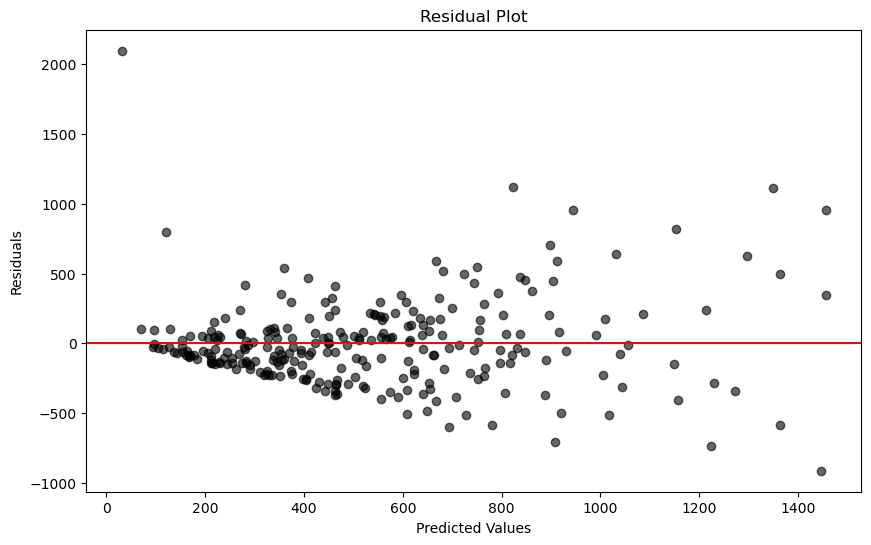

In [113]:
# Fit the model to the entire dataset
lr_pipeline_elastic.fit(X, y)

# Get predicted y values for the entire dataset
lr_predicted_1 = lr_pipeline_elastic.predict(X)

# Calculate residuals as the difference between actual and predicted values
residuals = y - lr_predicted_1  # Ensure both y and lr_predicted_1 have the same shape

# Plot residuals
#aspect ratio
plt.figure(figsize=(10, 6))
plt.scatter(lr_predicted_1, residuals, alpha=0.6, color="black")
#horizontal line
plt.axhline(y=0, color="red")
#labs
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


**Residual Plot of a Significantly Worst Model**

In [114]:
#pipeline

ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that division by itself is not included in the model
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ("interaction_Hits_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction_CRBI_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction_Walks_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__Walks", "dummify__Division_W"]),
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

#elastic pipeline
lr_pipeline_elastic = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  #can now put our custom alpha and l1_ratio that we found in the previous step
  ("elastic_regression", ElasticNet(alpha = 100, l1_ratio = .2))]
).set_output(transform="pandas")


In [115]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

#R^2
scores = cross_val_score(lr_pipeline_elastic, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_elastic, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

r2:  0.025326461104620158  mse:  193114.28872800322
r2:  0.025326461104620158  mse:  193114.28872800322


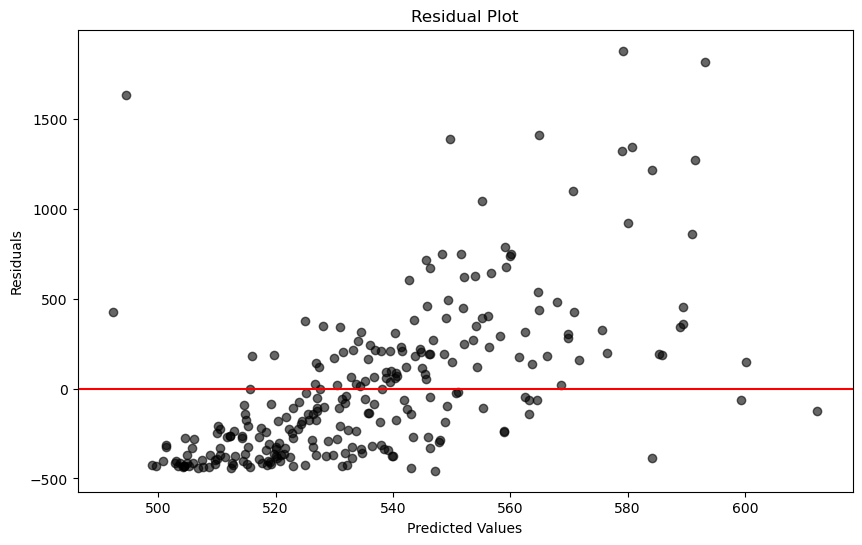

In [116]:
# Fit the model to the entire dataset
lr_pipeline_elastic.fit(X, y)

# Get predicted y values for the entire dataset
lr_predicted_1 = lr_pipeline_elastic.predict(X)

# Calculate residuals as the difference between actual and predicted values
residuals = y - lr_predicted_1  # Ensure both y and lr_predicted_1 have the same shape

# Plot residuals
#aspect ratio
plt.figure(figsize=(10, 6))
plt.scatter(lr_predicted_1, residuals, alpha=0.6, color="black")
#horizontal line
plt.axhline(y=0, color="red")
#labs
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


**Residual Plot Conclusion**

From these plots we can see that the residual plot is a lot better for a model with a higher R^2 value, overall neither of these models are amazing, but it is definitely easy to see which one is better in this case.

Some indictors to see if a model does better when plotting predicted values with their residual is that it is a lot more align with the the red horizontal line that I plotted (that is because that is where the residual would be 0)